## Model 3

This first model consists of a simple 3D autoencoder with 2 conv3D and 2 conv3DTranspose. Compression ratio is (2^3)^4 = 4096 divided across 20 filters, that would make: 4096/20 = 204.8 = CP. 

In [1]:
import time
import numpy as np
import xarray as xr
import tensorflow as tf
from collections import OrderedDict
from keras.callbacks import LearningRateScheduler
from lossycomp.dataLoader import DataGenerator, data_preprocessing, split_data, norm_data
from lossycomp.utils import check_gpu, Autoencoder, decay_schedule, r2_coef
from lossycomp.plots import mult_plot, single_plot, plot_history

In [2]:
 model = Autoencoder((16, 48, 48, 1), [10, 20, 20,20], [4, 4, 4, 4], [2, 2, 2, 2])

In [3]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 48, 48, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 8, 24, 24, 10)     650       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 4, 12, 12, 20)     12820     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 6, 6, 20)       25620     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 3, 3, 20)       25620     
_________________________________________________________________
conv3d_transpose (Conv3DTran (None, 2, 6, 6, 20)       25620     
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 4, 12, 12, 20)    

In [4]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

In [5]:
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})

file = '/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc'
region = "europe"
var = OrderedDict({'t': 1000})

z, mean, std = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=48, latitude=48, level=1)

dg_train = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std) 
dg_test = DataGenerator(test, 20000, leads, batch_size=100, load=True, mean= mean, std=std)

Loading data into RAM
Loading data into RAM


In [6]:
lr_scheduler = LearningRateScheduler(decay_schedule)

In [7]:
history = model.fit(dg_train, validation_data = dg_test, epochs=100, callbacks=[lr_scheduler])#,workers = 4)#, use_multiprocessing = True)

Epoch 1/100
1000/1000 [==============================] - 52s 52ms/step - loss: 0.5054 - r2_coef: 0.6925 - MAE: 0.4327 - val_loss: 0.2778 - val_r2_coef: 0.8291 - val_MAE: 0.3086
Epoch 2/100
1000/1000 [==============================] - 51s 51ms/step - loss: 0.1820 - r2_coef: 0.8898 - MAE: 0.2329 - val_loss: 0.1311 - val_r2_coef: 0.9184 - val_MAE: 0.2163
Epoch 3/100
1000/1000 [==============================] - 51s 51ms/step - loss: 0.0883 - r2_coef: 0.9465 - MAE: 0.1681 - val_loss: 0.0769 - val_r2_coef: 0.9534 - val_MAE: 0.1736
Epoch 4/100
1000/1000 [==============================] - 50s 50ms/step - loss: 0.0525 - r2_coef: 0.9679 - MAE: 0.1329 - val_loss: 0.0552 - val_r2_coef: 0.9658 - val_MAE: 0.1545
Epoch 5/100
1000/1000 [==============================] - 50s 50ms/step - loss: 0.0378 - r2_coef: 0.9770 - MAE: 0.1186 - val_loss: 0.0467 - val_r2_coef: 0.9711 - val_MAE: 0.1443
Epoch 6/100
1000/1000 [==============================] - 50s 50ms/step - loss: 0.0259 - r2_coef: 0.9841 - MAE: 0.10

In [8]:
model.save_weights('model3/weights')
#model.load_weights('model3/weights')

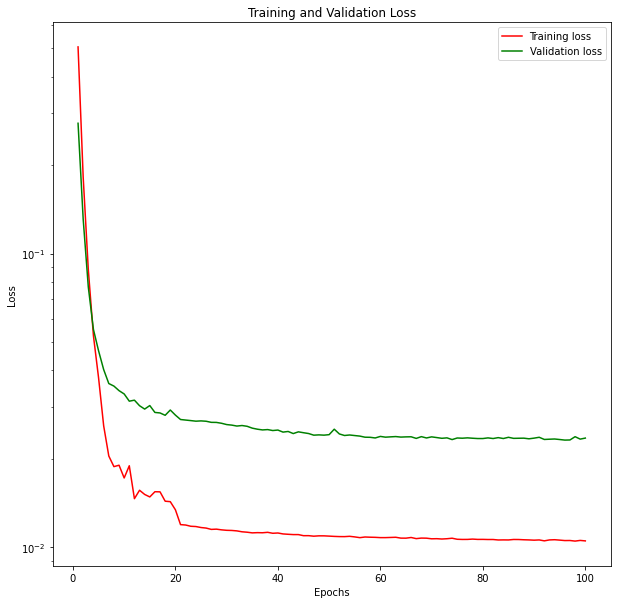

In [9]:
plot_history(history, 'loss', 'Training and Validation Loss', 'Epochs', 'Loss')

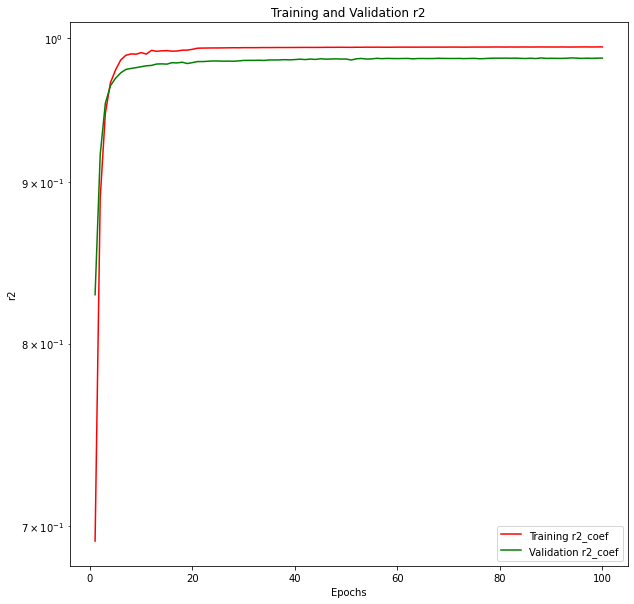

In [10]:
plot_history(history, 'r2_coef', 'Training and Validation r2', 'Epochs', 'r2')

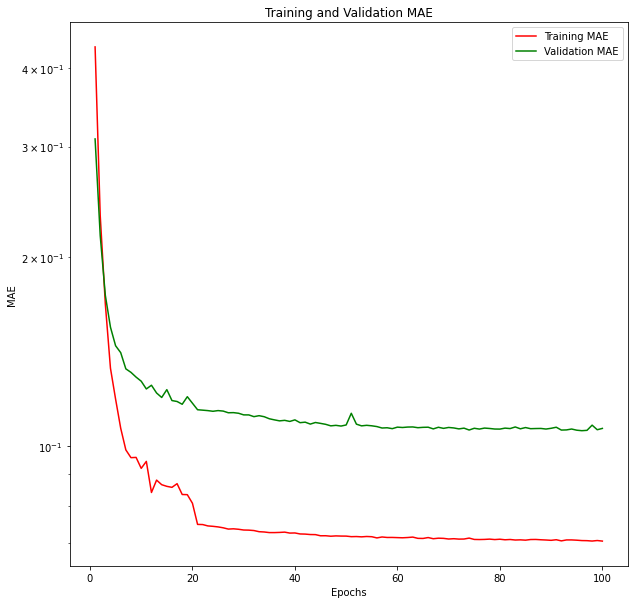

In [11]:
plot_history(history, 'MAE', 'Training and Validation MAE', 'Epochs', 'MAE')

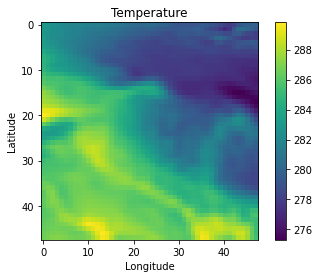

In [12]:
a = dg_test.__getitem__(2)[0] 
a_n = norm_data(a, mean, std)
single_plot(a_n, 10, "Temperature")

In [13]:
import numpy as np
result = model(np.expand_dims(a[0], axis=0)).numpy()

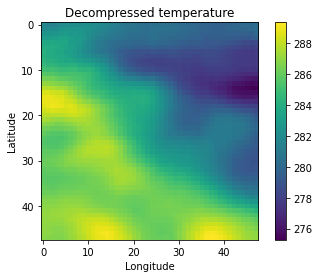

In [14]:
result = norm_data(result, mean, std)
single_plot(result, 10, "Decompressed temperature" )

In [23]:
test = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1980/*/ERA5.pl.temperature.nc', combine='by_coords')
test_data = test.sel(time=slice('1980-01-14T16:00:00','1980-01-15T07:00:00'),level = slice(978,1000), longitude=slice(6,17.75), latitude=slice(55.5,43.75))
test_data = test_data.transpose('time', 'latitude', 'longitude', 'level')
test_data = (test_data['t'] - mean) / std
test_data = np.expand_dims(test_data.values, axis=0)
test_data.shape

(1, 16, 48, 48, 1)

## Results

Original:

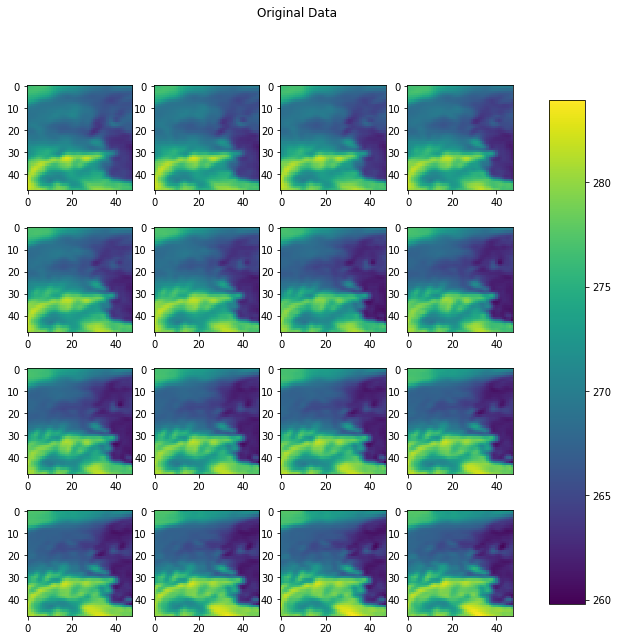

In [24]:
test_n = norm_data(test_data, mean, std)
mult_plot(test_n, 4, 4, "Original Data", test_n.min(), test_n.max())

Decompressed:

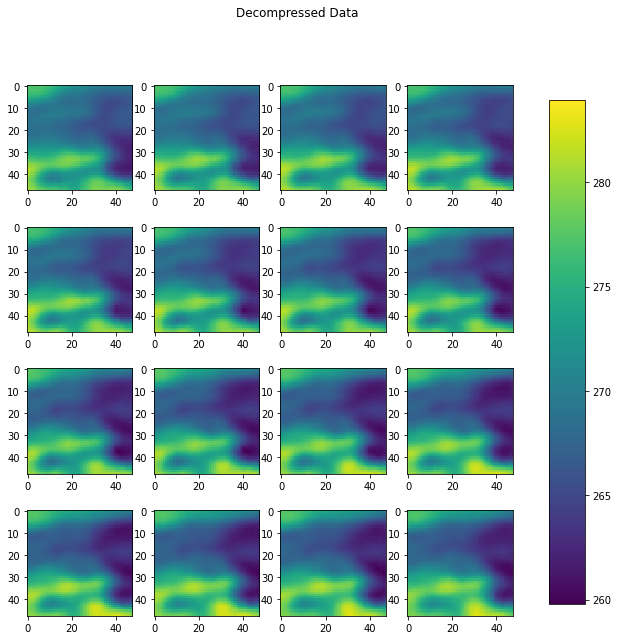

In [25]:
result2 = model(test_data).numpy()
result2 = norm_data(result2, mean, std)

mult_plot(result2, 4, 4, "Decompressed Data", test_n.min(), test_n.max())

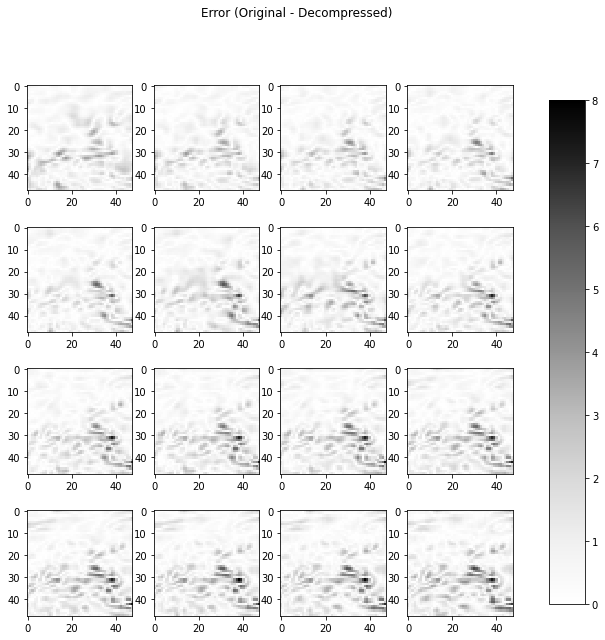

In [26]:
result3 = np.absolute(test_n-result2)
mult_plot(result3, 4, 4, "Error (Original - Decompressed)", result3.min(), result3.max(), 'Greys')

## Validation

In [51]:
file = '/lsdf/kit/scc/projects/abcde/1980/*/ERA5.pl.temperature.nc'
region = "europe"
var = OrderedDict({'t': 1000})

z, mean, std = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=40, latitude=40, level=1)

dg_validation = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std) 

Loading data into RAM


In [52]:
results = model.evaluate(dg_validation)

1000/1000 [==============================] - 37s 37ms/step - loss: 0.0024 - r2_coef: 0.9985 - MAE: 0.0320


In [53]:
results

[0.002380184130743146, 0.9985009431838989, 0.03197915479540825]